# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Scanpy

[scanpy](https://scanpy.readthedocs.io/en/stable/) is the main toolkit for single-cell RNA-seq data preprocessing and analysis. [Seurat](https://satijalab.org/seurat/) is the alternative package for single-cell RNA-seq data analysis in R.

In this lecture, we will work through the main functionality of `scanpy` for analyzing single-cell data. 
- We will start by understanding the `Anndata` class which is the data container of `scanpy`. 
- We will perform QC of a publicly available dataset made by available by 10X using scanpy functions. [Download](https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5) the attached file into the `data` directory. This is a single-cell RNA-seq dataset of peripheral mononuclear blood cells from a healthy donor
- We will then cluster, generating umaps and annotate cell-types in this data.

Extensive tutorials about scanpy usage are available [here](https://scanpy.readthedocs.io/en/stable/tutorials.html).

# Anndata

<img src="assets/anndata.png" style="width: 600px;"/>


`AnnData` is the central data container similar to `SummarizedExperiment` class we encounted during bulk RNA-seq analysis. These are the main components of the an `AnnData` object.

- `.X`: Expression matrix of cells X genes (Note that in R, genes X cells representation is used). This could be raw or normalized data. 
- `.obs`: `pandas` dataframe with information about cells. Each row is a cell. The number of rows in `.obs` is same as the number of rows in `.X`. Columns contain annotations about cells. E.g., sample, cluster, cell type etc..
- `.var`: Similar to `.obs` but with information about genes.
- `.obsm`: Dictionary of matrices about cells. Each entry of `.obsm` has the same number of rows as `.X` and `.obs`. This could matrix properties such as UMAPs, PCs etc.
- `.varm`: Similar to `.obsm` for genes 
- `.uns`: Dictionary of dictionaries with unstructured information. E.g: cluster colors, cell type colors

## Load anndata

Lets start with loading a previously computed anndata using the `scanpy.read` function. You can download the object from [here](https://drive.google.com/file/d/1Wfd6jHnLFsOBheMfzgryRjYei0xGJsFN/view?usp=share_link). Download it to the `data/` folder- this is the same object we explored using `cellxgene` in the previous lecture.

In [4]:
# Load the 10x_pbmc.h5ad object
ad = sc.read('data/10x_pbmc.h5ad')

In [5]:
# Print out the ad object
ad

AnnData object with n_obs × n_vars = 7460 × 11865
    obs: 'leiden', 'celltype', 'log_n_counts'
    uns: 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

<b> Questions </b>
1. How many cells and genes are present in this dataset? 
2. What do you think is the dimension of `ad.obs` pandas dataframe ?


## Anndata exploration

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

In [6]:
ad.obs_names

Index(['AAACCCAAGATTGTGA-1', 'AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1',
       'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1', 'AAACCCAGTGCAAGAC-1',
       'AAACCCAGTGCATTTG-1', 'AAACCCATCCGATGTA-1', 'AAACCCATCTCAACGA-1',
       'AAACCCATCTCTCGAC-1',
       ...
       'TTTGTTGAGGCCACCT-1', 'TTTGTTGCACGAAAGC-1', 'TTTGTTGCAGAGGAAA-1',
       'TTTGTTGGTCTCTCAC-1', 'TTTGTTGGTGGCCACT-1', 'TTTGTTGGTTCAAGTC-1',
       'TTTGTTGGTTGCATGT-1', 'TTTGTTGGTTGCGGCT-1', 'TTTGTTGTCGAGTGAG-1',
       'TTTGTTGTCGTTCAGA-1'],
      dtype='object', length=7460)

As you can see each cell name is a nucleotide sequence indicating the cell barcode

In [7]:
ad.var_names

Index(['AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17', 'HES4', 'ISG15',
       'C1orf159', 'TNFRSF18', 'TNFRSF4',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'AL592183.1', 'AC007325.4', 'AC004556.1'],
      dtype='object', length=11865)

Lets examine the `.obs` entry:

In [8]:
# head function lists the top n rows in the table
# Reiteration - ad.obs is just a dataframe and all pandas functions can be used.
ad.obs.head(n=10)

,leiden,celltype,log_n_counts
AAACCCAAGATTGTGA-1,1,CD14 Monocytes 2,3.789581
AAACCCACATCGGTTA-1,1,CD14 Monocytes 2,3.826917
AAACCCAGTACCGCGT-1,1,CD14 Monocytes 1,3.560743
AAACCCAGTCGTCATA-1,3,NK cells 1,3.416807
AAACCCAGTCTACACA-1,4,CD14 Monocytes 1,3.701999
AAACCCAGTGCAAGAC-1,1,CD14 Monocytes 1,3.657725
AAACCCAGTGCATTTG-1,4,CD14 Monocytes 1,3.901840
AAACCCATCCGATGTA-1,0,CD4 T cells 1,3.472610
AAACCCATCTCAACGA-1,0,CD4 T cells 1,3.522966
AAACCCATCTCTCGAC-1,0,CD4 T cells 1,3.585686


In [9]:
ad.obs['celltype'].unique()

['CD14 Monocytes 2', 'CD14 Monocytes 1', 'NK cells 1', 'CD4 T cells 1', 'CD4 T cells 2', ..., 'pro B cells 1', 'NK cells 2', 'NK cells 3', 'NKT cells', 'pDC']
Length: 17
Categories (17, object): ['B cell precursor', 'CD4 T cells 1', 'CD4 T cells 2', 'CD8 T cells 1', ..., 'NKT cells', 'pDC', 'pro B cells 1', 'pro B cells 2']

## Subsetting anndata

Anndata objects can be subset using cell names, gene names, logical vectors for cells and genes

In [10]:
# Anndata object with cell "AAACCCAAGATTGTGA-1"
ad["AAACCCAAGATTGTGA-1", :]

View of AnnData object with n_obs × n_vars = 1 × 11865
    obs: 'leiden', 'celltype', 'log_n_counts'
    uns: 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

In [11]:
# Anndata object of pDC cells
ad[ad.obs['celltype'] == 'pDC', :]

View of AnnData object with n_obs × n_vars = 26 × 11865
    obs: 'leiden', 'celltype', 'log_n_counts'
    uns: 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

# Scanpy - plotting

`scanpy` contains the following broad categories of functions:

- `sc.pp`: Functions for preprocessing (Eg: PCA)
- `sc.tl`: Tool  interfaces (Eg. UMAP)
- `sc.pl`: Plotting
- `sc.external`: Interface for accessing tools developed by other labs (Eg:. `sc.external.tl.palantir`)

Lets start with visualizations that we already explored using `cellxgene`

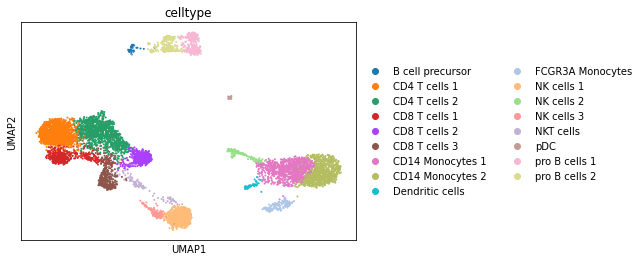

In [13]:
# Plot the umap colored by cell types
sc.pl.umap(ad, color='celltype')

The above function uses the `ad.obms['X_umap']` to plot the umap. If you want to use an alternative visualization, you can use the `sc.pl.scatter` function

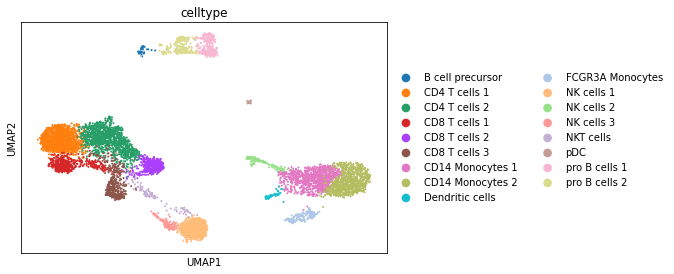

In [14]:
# Plot the umap colored by cell types
sc.pl.scatter(ad, color='celltype', basis='umap')

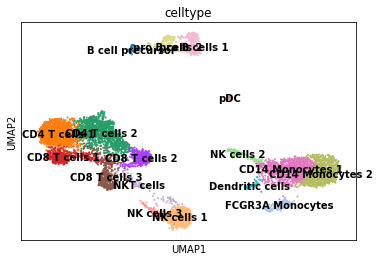

In [15]:
# We can highlight cell-types on the umap itself 
sc.pl.umap(ad, color='celltype', legend_loc='on data')

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


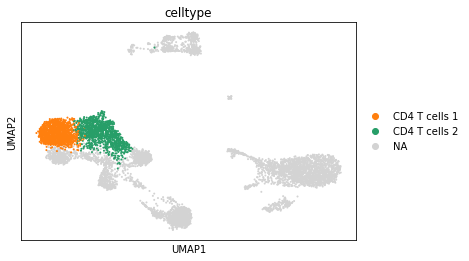

In [16]:
# Or plot specific cell types
sc.pl.umap(ad, color='celltype', groups=['CD4 T cells 1', 'CD4 T cells 2'])

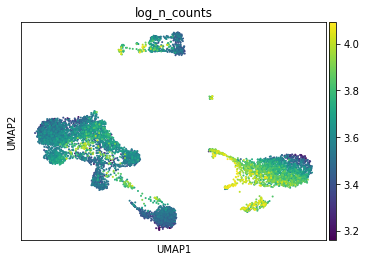

In [17]:
# UMAPs can be colored by continuous values too 
sc.pl.umap(ad, color='log_n_counts')

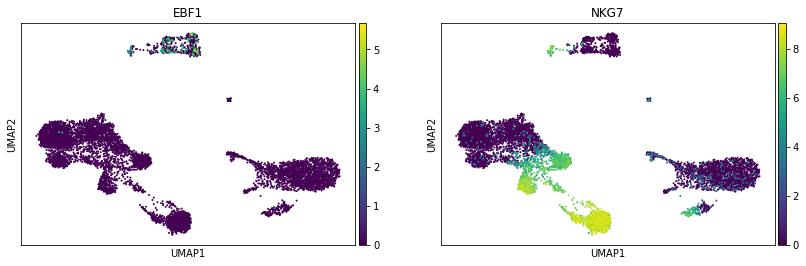

In [18]:
# Or by gene expression values 
sc.pl.umap(ad, color=['EBF1', 'NKG7'])

## Exercise 1 : 15 minutes

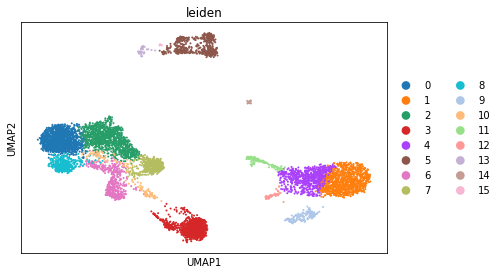

In [19]:
# Plot umap colored by leiden clusters using `sc.pl.scatter`. Hint: ad.obs['leiden'] contains all clusters


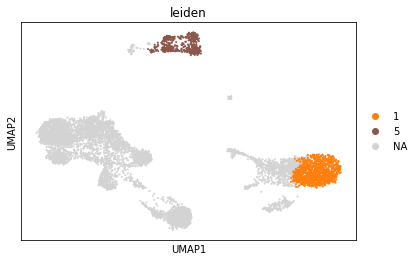

In [20]:
# Plot umap colored by leiden clusters using `sc.pl.umap` with clusters 1 and 5 highlighted


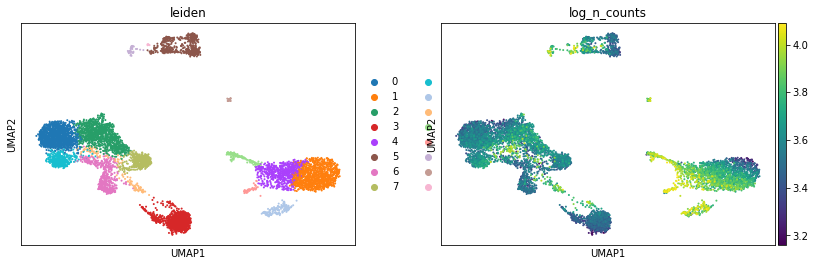

In [21]:
# Plot umap colored by leiden clusters and log_n_counts


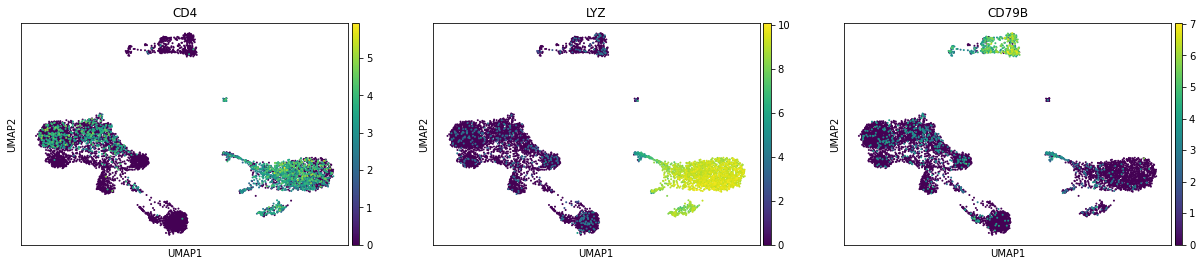

In [23]:
# Plot the expression of genes CD4, LYZ, CD79B on umap for all cells


In [27]:
# Create an anndata subset which contains only CD14 Monocytes 1 and name it sub_ad
sub_ad

View of AnnData object with n_obs × n_vars = 927 × 11865
    obs: 'leiden', 'celltype', 'log_n_counts'
    uns: 'celltype_colors', 'leiden_colors'
    obsm: 'X_umap'

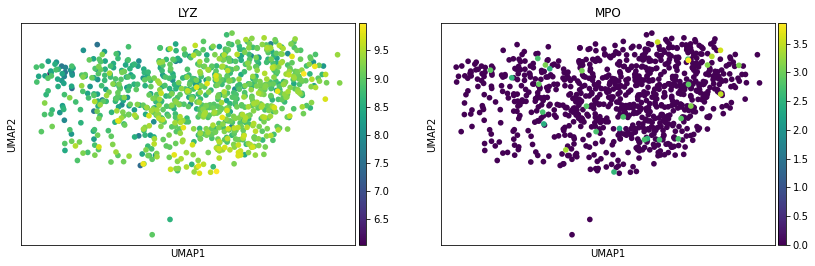

In [28]:
# Plot the expression of genes LYZ and MPO on umap for CD4 T cell clusters on this sub ad


We will explore more plotting functions later in the lecture

# Scanpy - preprocessing and analysis

Here, we will discuss how to identify cells, normalize, select informative genes and generate visualizations. An overview of single-cell data preprocessing and analysis is shown below

<img src="assets/sc-microfluidics.png" style="width: 1000px;"/>


<img src="assets/sc_pp.png" style="width: 1000px;"/>

## Count matrix generation

We will use data from `10X Genomics` for the purpose of this discussion. For data generated 10X platforms, the 10X [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) pipelines are used for count matrix generation. `cellranger` perform data alignment, barcode and UMI correction to generate count matrix. `cellranger` also identifying cell containing barcodes. 

We will perform QC of a publicly available dataset made by available by 10X. [Download](https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5) the attached file into the `data` directory. The downloaded file is an `h5` file which is a sparse matrix of cells X genes post-filtering.

Lets first examine the QC report for this data available [here](https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_web_summary.html)

In [19]:
# Load the data and create a new anndata object
pbmc_ad = sc.read_10x_h5('data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')
pbmc_ad.var_names_make_unique()

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [20]:
pbmc_ad

AnnData object with n_obs × n_vars = 7865 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [21]:
# Lets remove genes that are not detected in less than 10 cells [this is just a rule of thumb]
sc.pp.filter_genes(pbmc_ad, min_cells=10)

In [22]:
pbmc_ad
# Notice that the number of genes dropped from ~33k to ~15k
# Also notice that pbmc_ad.var now has a new entry 'n_cells'

AnnData object with n_obs × n_vars = 7865 × 15365
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## QC metrics and cell filtering

`scanpy` provides a wrapper function for all the necessary QC metrics, called `calculate_qc_metrics`

This function requires the specification of mitochondrial genes to compute the fraction of reads that are derived from mitochondria.

In [23]:
# Identify mitochondrial genes
pbmc_ad.var['mt'] = pbmc_ad.var_names.str.startswith('MT-')

In [24]:
pbmc_ad
# This should now have an additional columns in `var'. This is typically how scanpy functions work 
# - they update the anndata object with the computed information

AnnData object with n_obs × n_vars = 7865 × 15365
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt'

In [25]:
# Lets look at the documention of `calculate_qc_metrics`
?sc.pp.calculate_qc_metrics

Signature:
sc.pp.calculate_qc_metrics(
    adata: anndata._core.anndata.AnnData,
    *,
    expr_type: str = 'counts',
    var_type: str = 'genes',
    qc_vars: Collection[str] = (),
    percent_top: Optional[Collection[int]] = (50, 100, 200, 500),
    layer: Optional[str] = None,
    use_raw: bool = False,
    inplace: bool = False,
    log1p: bool = True,
    parallel: Optional[bool] = None,
) -> Optional[Tuple[pandas.core.frame.DataFrame, pandas.core.frame.DataFrame]]
Docstring:
Calculate quality control metrics.

Calculates a number of qc metrics for an AnnData object, see section
`Returns` for specifics. Largely based on `calculateQCMetrics` from scater
[McCarthy17]_. Currently is most efficient on a sparse CSR or dense matrix.

Note that this method can take a while to compile on the first call. That
result is then cached to disk to be used later.

Parameters
----------
adata : AnnData
    Annotated data matrix.
expr_type : str, optional (default: 'counts')
    Name of kind of va

In [26]:
sc.pp.calculate_qc_metrics(pbmc_ad, qc_vars=['mt'], 
                           inplace=True, log1p=False)
pbmc_ad

AnnData object with n_obs × n_vars = 7865 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

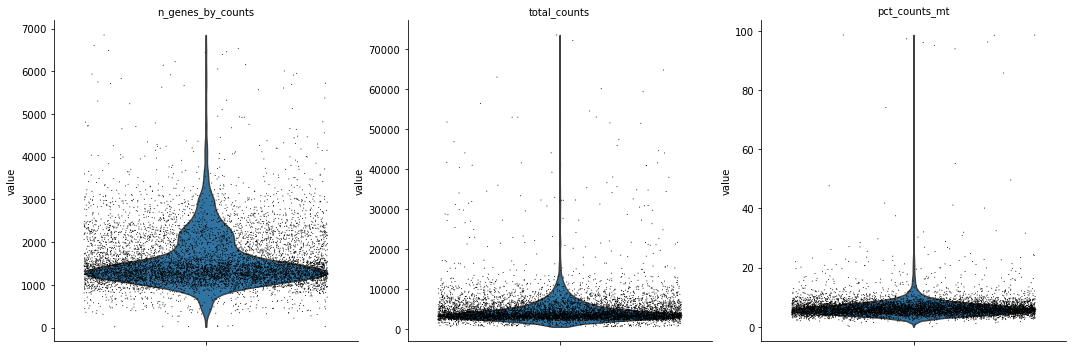

In [27]:
# Violin plots are a good way to visualize distributions of metrics
sc.pl.violin(pbmc_ad, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Filter based on molecule counts

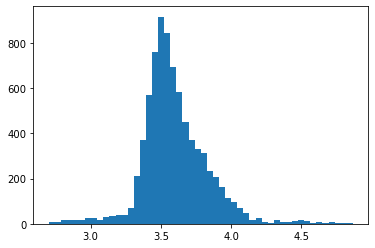

In [28]:
# Histograms are also a great way to visualize empirical distributions
plt.hist(np.log10(pbmc_ad.obs['total_counts']), 50);

Low molecule "cells" are a result of ambient RNA and very high molecule cells are most likely doublets. We will manually set thresholds to remove the outlier cells. While this is rather subjective, it works reasonably well in practice. [EmptyDrops](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y) is a method to automatically remove empty droplets but gives mixed results.  Doublets can be detected with different methods: [DoubletDetection](https://github.com/JonathanShor/DoubletDetection) and [scrublet](https://github.com/AllonKleinLab/scrublet) both work well in practice. Both methods are based on creation of artificial doublets in the data to detect true doublets. The set thresholds are shown below.

Text(0, 0.5, 'Frequency')

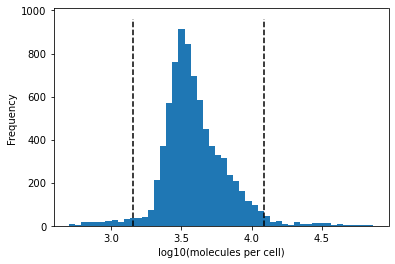

In [29]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((pbmc_ad.obs['total_counts']), [2.5, 97.5]))

plt.figure()
ax = plt.gca()
plt.hist(np.log10(pbmc_ad.obs['total_counts']), 50)
plt.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
plt.xlabel('log10(molecules per cell)')
plt.ylabel('Frequency')

In [30]:
# Filter cells 
use_cells = pbmc_ad.obs_names[(np.log10(pbmc_ad.obs['total_counts']) > THRESHOLDS[0]) & \
    (np.log10(pbmc_ad.obs['total_counts']) < THRESHOLDS[1]) ]
pbmc_ad = pbmc_ad[use_cells, :]

In [31]:
pbmc_ad

View of AnnData object with n_obs × n_vars = 7471 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Filter based on mitochondrial fraction

Warning: This filter removes "dying" cells. If your study involves investigation of such cells, you should not apply this filter!

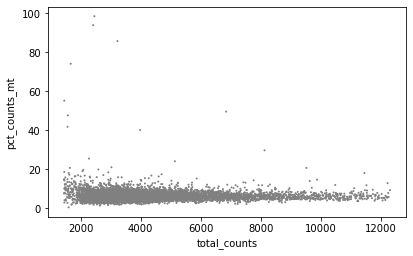

In [32]:
sc.pl.scatter(pbmc_ad, x='total_counts', y='pct_counts_mt')


In [33]:
# Retain cells with less than 20% mitochondrial fraction
pbmc_ad = pbmc_ad[pbmc_ad.obs['pct_counts_mt'] < 20, :]

In [34]:
pbmc_ad

View of AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalization

Molecule counts need to be normalized across cells given the large differences. Typically, normalization is performed by dividing the counts by total molecule counts for each cell. The data is then log transformed. There are more sophisticated methods to normalize data such as [scran](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7) and [scTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1), which also work well in practice.

In [35]:
# Scanpy function for normalization and log transform
sc.pp.normalize_total(pbmc_ad)
sc.pp.log1p(pbmc_ad)

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [36]:
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### Layers

<b> Warning: </b> Normalization and log transform *overwrite* `ad.X` - make sure you do not run the log transformation multiple times when you are interacting with the data

In [37]:
# A simple rule of thumb: If the maximum value is small float number not in 100s, the data is normalized and 
# log transformed
pbmc_ad.X.max()

6.9383893

Multiple views of the data can be stored using anndata. They are typically stored in `ad.layers`

For eg, lets scale (z-score) expression of each gene across cells

`sc.pp.scale` would be default overwrite `ad.X`. Therefore, we will make a copy and store it in `.layers['scaled']`

In [38]:
pbmc_ad.layers['scaled'] = sc.pp.scale(pbmc_ad, copy=True).X

In [39]:
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'scaled'

## Analysis

Typically, genes that are most variable across the data are selected for downstream analysis. The signal in the data can be masked if gene selection is not performed since cells artificially appear more similar to each other because of house keeping genes.

<img src="assets/sc_feature_selection.png" style="width: 1000px;"/>

In [40]:
sc.pp.highly_variable_genes(pbmc_ad)
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'scaled'

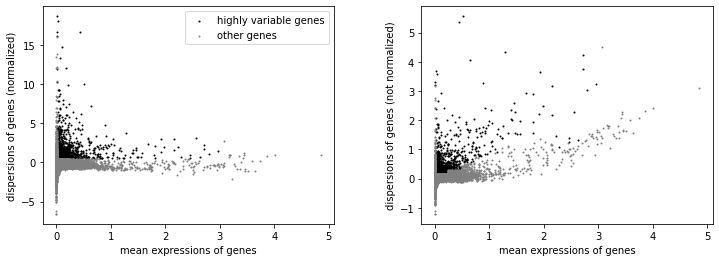

In [41]:
# The results can be visualized using
sc.pl.highly_variable_genes(pbmc_ad)

PCA is the first dimensionality reduction step after preprocessing. PCA is an essential step to overcome the noise due to dropouts. We take advantage of the covariate structure among genes to identify "meta-genes" that are represented by principal components. While these are linear combinations of genes, they provide a good starting point to perform downstream analysis. The number of components can be chosen by either the knee point or fraction of variance explained (E.g.: 85%)

In [42]:
sc.pp.pca(pbmc_ad)

In [43]:
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled'

In [44]:
# Lets look at the function documentation
?sc.pp.pca

Signature:
sc.pp.pca(
    data: Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse.base.spmatrix],
    n_comps: Optional[int] = None,
    zero_center: Optional[bool] = True,
    svd_solver: str = 'arpack',
    random_state: Union[NoneType, int, numpy.random.mtrand.RandomState] = 0,
    return_info: bool = False,
    use_highly_variable: Optional[bool] = None,
    dtype: str = 'float32',
    copy: bool = False,
    chunked: bool = False,
    chunk_size: Optional[int] = None,
) -> Union[anndata._core.anndata.AnnData, numpy.ndarray, scipy.sparse.base.spmatrix]
Docstring:
Principal component analysis [Pedregosa11]_.

Computes PCA coordinates, loadings and variance decomposition.
Uses the implementation of *scikit-learn* [Pedregosa11]_.

.. versionchanged:: 1.5.0

    In previous versions, computing a PCA on a sparse matrix would make a dense copy of
    the array for mean centering.
    As of scanpy 1.5.0, mean centering is implicit.
    While results are extremely similar, t

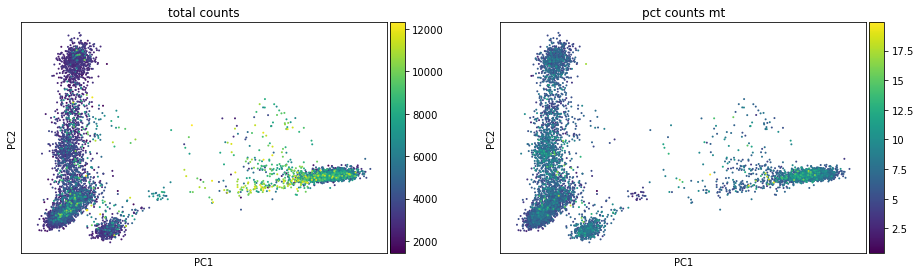

In [45]:
# Plot PCA and color the total and counts and percent of mito using sc.pl.scatter
sc.pl.scatter(pbmc_ad, basis='pca', color=['total_counts', 'pct_counts_mt'])

## Clustering and visualization

Nearest neighbor graphs are the most commonly used entities in single-cell data analysis. As we discussed in the last lecture, both clustering and UMAP visualization rely on nearest neighbor graphs. 

In [46]:
# Lets compute nearest neighbor graphs
sc.pp.neighbors(pbmc_ad)

In [47]:
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

In [48]:
# Cluster and Visualization
# Notice that we are using sc.tl and not sc.pp
sc.tl.leiden(pbmc_ad)
pbmc_ad

AnnData object with n_obs × n_vars = 7456 × 15365
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

In [49]:
sc.tl.umap(pbmc_ad)

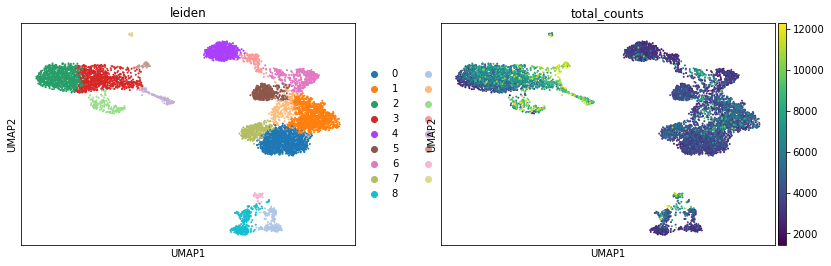

In [50]:
# Plot umaps colored by clusters and total counts
sc.pl.umap(pbmc_ad, color=['leiden', 'total_counts'])

# Visualization

A set of known markers per cell-type might be readily available for the biological system under study

In [51]:
marker_genes = ['IL7R', 'CD4', # CD4 T cells
                'CD14', 'LYZ', # Monocytes
                'CD79A', 'MS4A1', # B cells
                'CD8A', 'CD8B', # CD8 T cells
                'GNLY', 'NKG7', # NK cells
                'FCGR3A', 'MS4A7', # FCGR3A+ Monocytes
                'FCER1A', 'CST3', # Dendritic cells
                'PPBP', # Platelet
                'ITGA2B'# Megakaryocytes,
               ]

Simplest way to visualize gene expression is using umaps

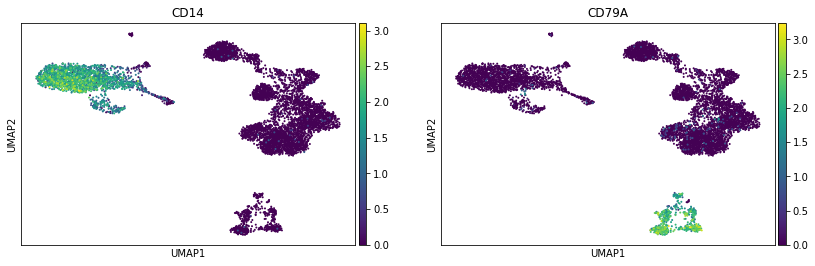

In [52]:
sc.pl.umap(pbmc_ad, color=['CD14', 'CD79A'])

We can plot scaled expression values by specifying the layers

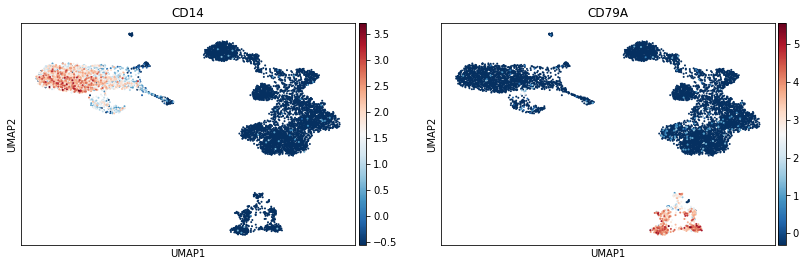

In [53]:
sc.pl.umap(pbmc_ad, color=['CD14', 'CD79A'], layer='scaled', 
          cmap='RdBu_r')

Dot plots are a good way to visualize these genes per cluster

In [54]:
# We will create a dictionary of marker genes 
marker_genes_dict = {
    'CD4 T-cell': ['IL7R', 'CD4'],
    'Monocytes': ['CD14', 'LYZ'],
    'B-cell': ['CD79A', 'MS4A1'],
    'CD8 T-cell': ['CD8A', 'CD8B'],
    'NK': ['GNLY', 'NKG7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'FCGR3A + Monocyte': ['FCGR3A', 'MS4A7'],
    'Platelet': ['PPBP'],
    'Megakaryocytes': ['ITGA2B']
}


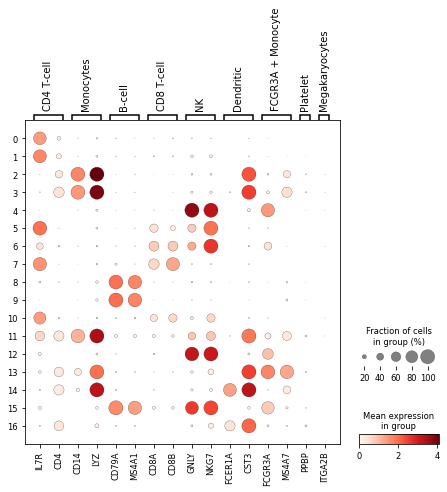

In [55]:
sc.pl.dotplot(pbmc_ad, marker_genes_dict, groupby='leiden');

<b> Questions </b>
- What cell types are clusters 0 and 2?
- Which cluster do you think are megakaryocyte cells


Another visualization is to use heatmaps

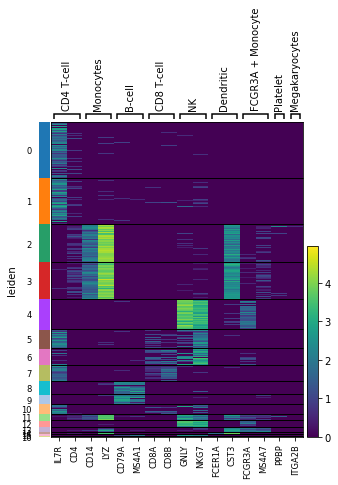

In [56]:
sc.pl.heatmap(pbmc_ad, marker_genes_dict, groupby='leiden')
# Note that this is a good way to visualize expression per cell

categories: 0, 1, 2, etc.
var_group_labels: CD4 T-cell, Monocytes, B-cell, etc.


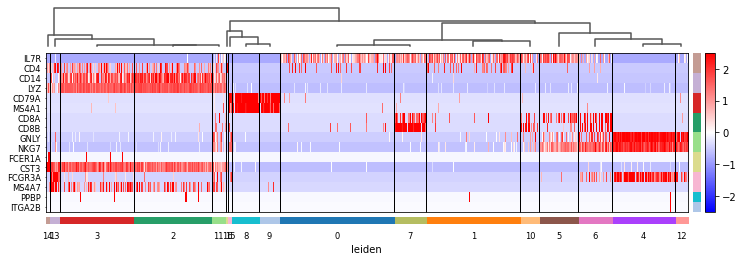

In [57]:
# Lets play a bit with parameters
sc.pl.heatmap(pbmc_ad, marker_genes_dict, groupby='leiden', 
              layer='scaled', # Z-score each gene
              vmin=-2.5, vmax=2.5, # Set axis limits 
              cmap='bwr', # Good to use diverging color maps when plotting positive and negative values 
              dendrogram=True, 
              swap_axes=True, 
              figsize=(12,4))


# Differential expression

Differential expression analysis is used for similar purposes we discussed with bulk data analysis. Rather than undertake analysis at patient / sample level, with single-cell analysis the differential expression analysis is between groups of cells - typically clusters or cell types.

`scanpy` provides a simple interface for identifying and visualizing differentially expression genes. The tests are reasonably reliable but [MAST](https://www.bioconductor.org/packages/release/bioc/html/MAST.html) takes a more principled approach and gives better results. 

In [58]:
# Differential expression per leiden cluster. 
# By default this compute differential genes for each clusters using *all* other cells are the reference
sc.tl.rank_genes_groups(pbmc_ad, groupby='leiden')

The results can be visualized as a dot plot:

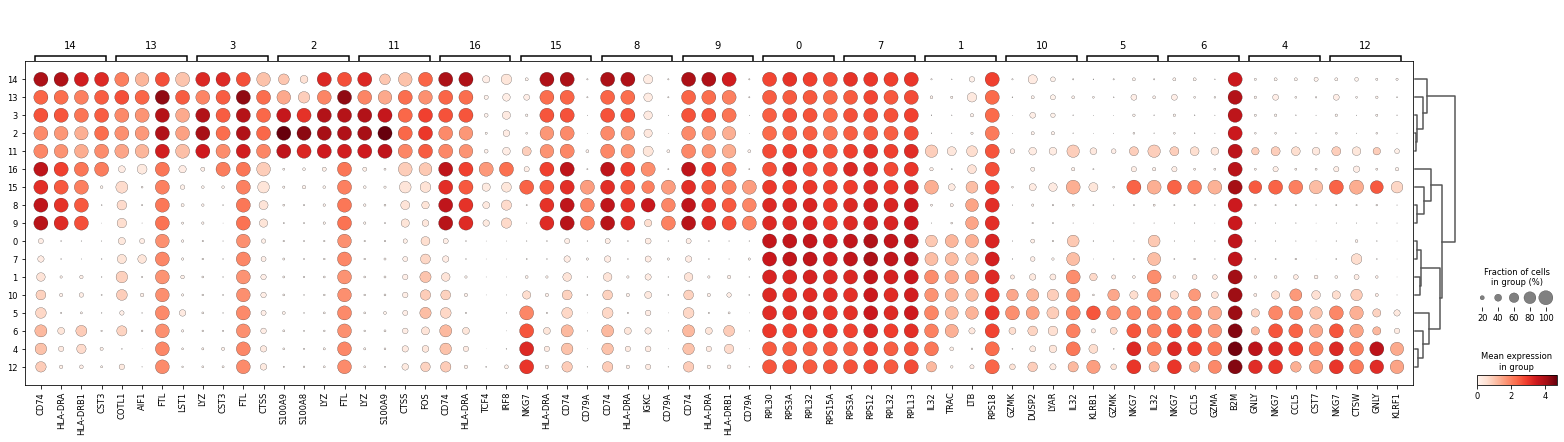

In [59]:
sc.pl.rank_genes_groups_dotplot(pbmc_ad, n_genes=4)

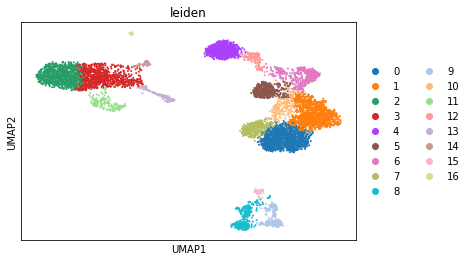

In [60]:
# A reminder of the clusters
sc.pl.umap(pbmc_ad, color=['leiden'])

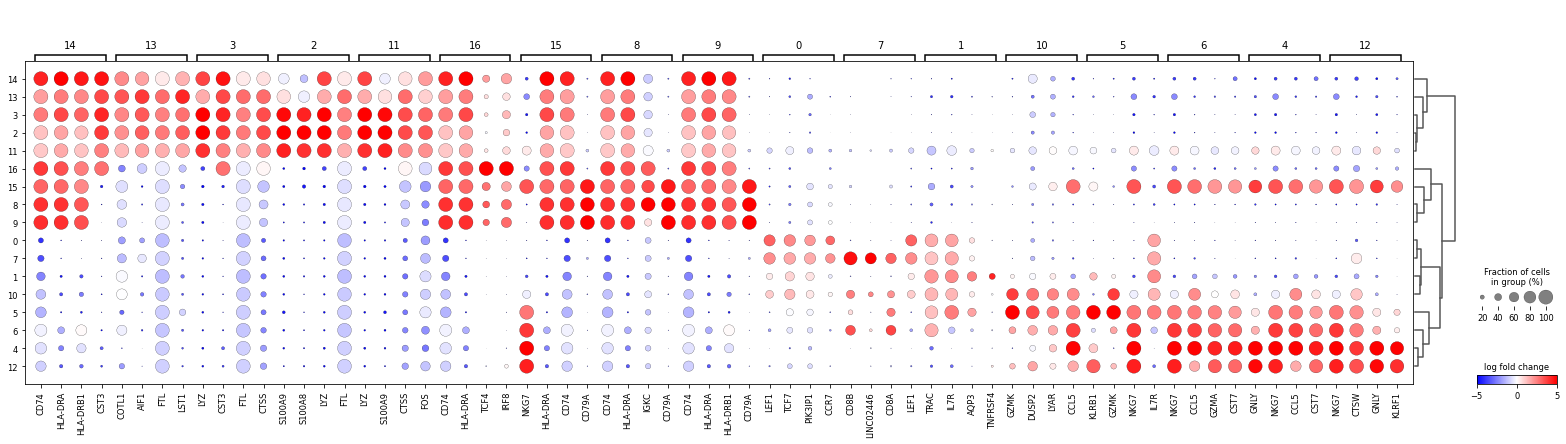

In [61]:
# Plot fold changes in each cluster instead of mean expression
sc.pl.rank_genes_groups_dotplot(pbmc_ad, n_genes=4, 
                                values_to_plot='logfoldchanges', min_logfoldchange=2,
                                vmax=5, vmin=-5, cmap='bwr')


Heatmaps are available too:

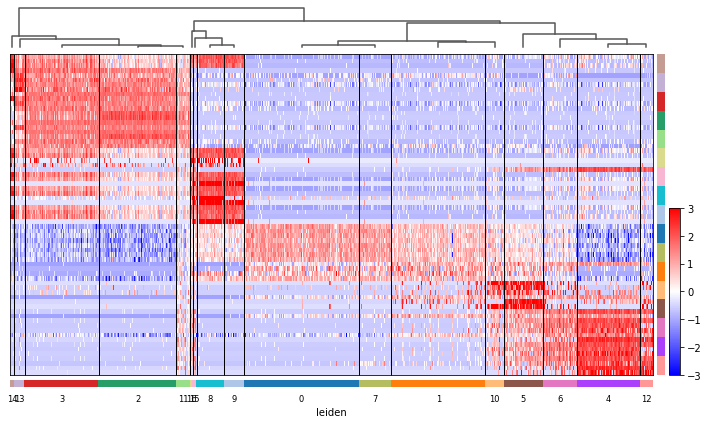

In [62]:
sc.pl.rank_genes_groups_heatmap(pbmc_ad, n_genes=4, use_raw=False, 
                                swap_axes=True, vmin=-3, vmax=3, cmap='bwr', 
                                layer='scaled', figsize=(12,7));

Differentially expressed genes per cluster can be accesssed using:

In [63]:
# Cluster 0 differential results
cluster0_genes = sc.get.rank_genes_groups_df(pbmc_ad, group='0', 
                            pval_cutoff=1e-2, log2fc_min=2)
cluster0_genes

,names,scores,logfoldchanges,pvals,pvals_adj
0,LEF1,40.815258,3.080286,1.509539e-247,1.148221e-245
1,TCF7,37.406799,2.329898,6.481162e-223,4.237577e-221
2,PIK3IP1,30.713337,2.029602,7.789318e-164,3.615797e-162
3,CCR7,29.422808,2.954644,5.357993e-150,2.177925e-148
4,TRABD2A,23.055422,2.703382,1.628103e-100,4.373391e-99
...,...,...,...,...,...
116,EFNA1,3.054672,3.217742,2.296504e-03,5.430253e-03
117,AC004771.1,3.023721,2.172907,2.541153e-03,5.956494e-03
118,EXPH5,2.993734,2.145828,2.802605e-03,6.503855e-03
119,SMARCA1,2.873143,3.155073,4.126228e-03,9.196328e-03


## Exercise 2 : 15 minutes

In [101]:
# Find the differentially expressed genes for cluster 8 using the same thresholds as above
cluster8_genes

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD74,74.752220,4.050607,3.674861e-258,1.613264e-255
1,HLA-DRA,66.538483,4.000243,2.604499e-236,9.528125e-234
2,IGKC,65.756485,6.506697,5.786850e-191,1.234930e-188
3,CD79A,56.303581,5.974658,3.907878e-172,6.598302e-170
4,HLA-DRB1,53.642033,3.300452,6.449429e-189,1.303888e-186
...,...,...,...,...,...
280,KCNH8,3.040962,5.301301,2.553301e-03,7.933562e-03
281,IGHE,3.028574,5.245178,2.657145e-03,8.215104e-03
282,C12orf42,3.023510,2.150197,2.697508e-03,8.322733e-03
283,SCX,2.989854,2.853236,3.005239e-03,9.185497e-03


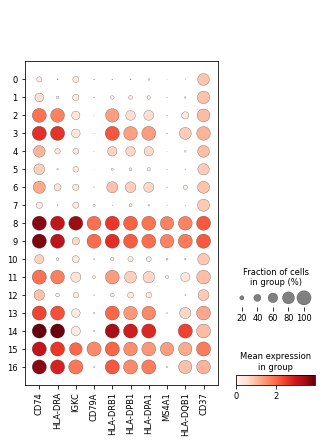

In [106]:
# Plot the expression of top 10 differentially genes in cluster 10 as dotplots
# Hint: Use sc.pl.dotplot


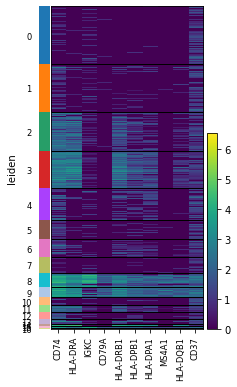

In [107]:
# Plot the same genes as a heatmap


In [110]:
# How many genes are common between the two clusters and how many are specific to cluster 0 and cluster 8 in these comparisons
# Hint: You will need to apply your pandas skills here


(0, 121, 285)

# Save and load

In [112]:
# Saving anndata is very simple
pbmc_ad.write('data/10x_pbmc_processed.h5ad')

In [113]:
# Loading is also simple
pbmc_ad = sc.read('data/10x_pbmc_processed.h5ad')

# Batch correction

Batch correction is an often encountered with biological data analysis in general. Batch effects are a result of many different factors: day of experiment, site of experiments, researcher handling the sampling, weather outside...

Batch effects can be rather nasty. See below for an [example of a large COVID scRNA-seq study](https://www.nature.com/articles/s41591-021-01329-2) without correcting for batch effects. The cell types are all mixed in and the major difference is the site of collection! (Cambridge -vs- Newcastle)

![title](assets/batcheffects.png)

<b> Warning 1</b>: Not all differences are batch effects. Differences in tumor cells from different patients could well be real biology and not batch effect. See [Figure 2](https://www.sciencedirect.com/science/article/pii/S0092867417312709?via%3Dihub) for this manuscript, which is one of the early example of scRNA-seq from patient samples. 

<b> Warning 2</b> If the patient data is provided as inputs for batch correct algorithms, they *will* remove the differences! This is because the algorithms assume that all the differences between samples are technical and not biological. An important thing to remember always is to carefully understand the assumptions of any algorithm before using them and only use them if the assumptions are valid and not violated in our system. 

## PBMC datasets

We will use two PBMC datasets generated using different versions of the 10X platform for exploring batch correction. The first dataset is the one we have used in the lecture so far. The second dataset summary is available [here](https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_web_summary.html). Please download [this](https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_X/10k_PBMC_3p_nextgem_Chromium_X_filtered_feature_bc_matrix.h5) to the `data/` directory.

We will use [Harmony](https://www.nature.com/articles/s41592-019-0619-0), one of the most used algorithms for batch correction. This is a very hot topic in research and a detailed comparison of different batch correction methods is available [here](https://www.nature.com/articles/s41592-021-01336-8).

In [64]:
# Load both the datasets
ds1_ad = sc.read_10x_h5('data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')
ds2_ad = sc.read_10x_h5('data/10k_PBMC_3p_nextgem_Chromium_X_filtered_feature_bc_matrix.h5')

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [65]:
ds1_ad.var_names_make_unique()
ds2_ad.var_names_make_unique()

In [66]:
ds1_ad, ds2_ad

(AnnData object with n_obs × n_vars = 7865 × 33538
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 11996 × 36601
     var: 'gene_ids', 'feature_types', 'genome')

In [67]:
# Set the dataset identifier in both anndatas
ds1_ad.obs['Dataset'] = 'DS1'
ds2_ad.obs['Dataset'] = 'DS2'

In [68]:
# Concatenate the two datasets to create  a single anndata object
# Notice that there are different number of genes in each dataset
#    the concatenate function by default uses the intersection of genes between the two datasets
comb_ad = ds1_ad.concatenate(ds2_ad)
comb_ad

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 19861 × 31915
    obs: 'Dataset', 'batch'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1'

## Analysis without batch correction

In this section, we will perform the typical steps for scRNA-seq analysis without any batch correction. For simplicity, we will ignore cell filtering steps

In [69]:
# Filter genes
sc.pp.filter_genes(comb_ad, min_cells=10)

In [70]:
# Normalize and log transform
sc.pp.normalize_total(comb_ad)
sc.pp.log1p(comb_ad)

In [71]:
# Highly variable genes and PCA
sc.pp.highly_variable_genes(comb_ad)
sc.pp.pca(comb_ad)

In [72]:
# Nearest neighbor graph computation, clustering and UMAP
sc.pp.neighbors(comb_ad)
sc.tl.umap(comb_ad)
sc.tl.leiden(comb_ad)

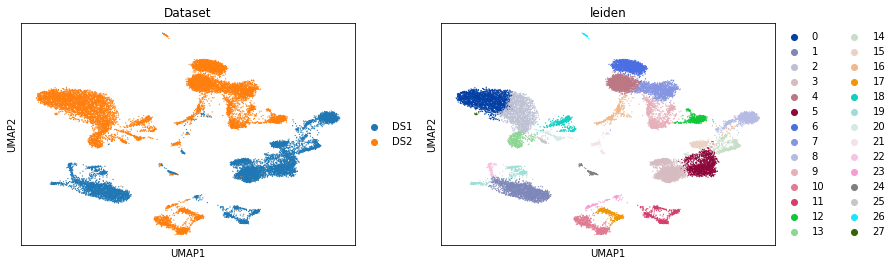

In [73]:
sc.pl.umap(comb_ad, color=['Dataset', 'leiden'])

<b> Questions </b>
- Does cluster 0 contain cells both datasets ?
- Does *any* cluster contain cells from both datasets ?

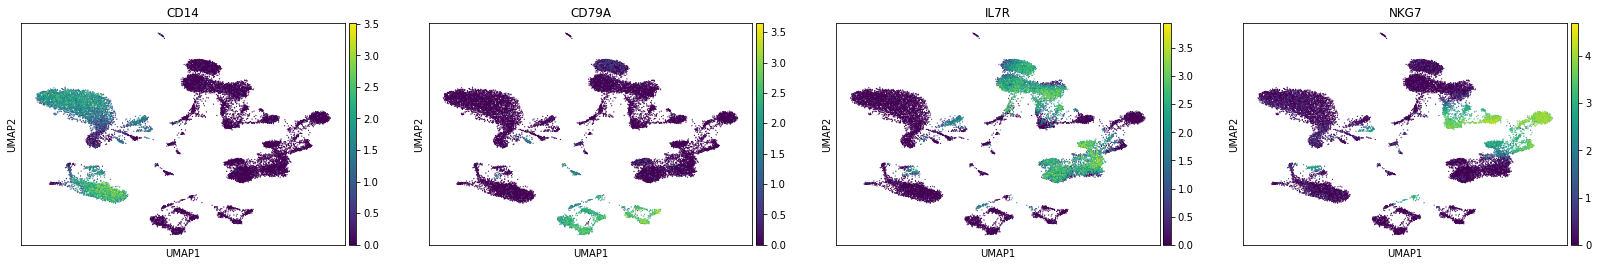

In [74]:
sc.pl.umap(comb_ad, color=['CD14', 'CD79A', 'IL7R', 'NKG7'])

## Analysis with batch correction

<b>Note: </b> Harmony works on PC and does not directly alter the actual gene expression. The corrected PCs are available under `.obsm['X_pca_harmony]`

In [75]:
sc.external.pp.harmony_integrate(comb_ad, key='Dataset')

2022-11-16 20:54:30,264 - harmonypy - INFO - Iteration 1 of 10
2022-11-16 20:54:38,069 - harmonypy - INFO - Iteration 2 of 10
2022-11-16 20:54:44,585 - harmonypy - INFO - Iteration 3 of 10
2022-11-16 20:54:51,972 - harmonypy - INFO - Iteration 4 of 10
2022-11-16 20:54:59,734 - harmonypy - INFO - Iteration 5 of 10
2022-11-16 20:55:06,969 - harmonypy - INFO - Iteration 6 of 10
2022-11-16 20:55:09,445 - harmonypy - INFO - Iteration 7 of 10
2022-11-16 20:55:13,952 - harmonypy - INFO - Iteration 8 of 10
2022-11-16 20:55:17,440 - harmonypy - INFO - Iteration 9 of 10
2022-11-16 20:55:19,858 - harmonypy - INFO - Iteration 10 of 10
2022-11-16 20:55:22,368 - harmonypy - INFO - Stopped before convergence


In [76]:
comb_ad

AnnData object with n_obs × n_vars = 19861 × 18047
    obs: 'Dataset', 'batch', 'leiden'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Dataset_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

`sc.tl.leiden` and `sc.tl.umap` overwrite existing results. Lets save them for comparison

In [77]:
comb_ad.obs['leiden_no_correction'] = comb_ad.obs['leiden']
comb_ad.obsm['X_umap_no_correction'] = comb_ad.obsm['X_umap']

In [78]:
sc.pp.neighbors(comb_ad, use_rep='X_pca_harmony')
# UMAP and leiden use results from the neighborhood computation. Therefore we dont need to specify harmony
sc.tl.umap(comb_ad)
sc.tl.leiden(comb_ad)

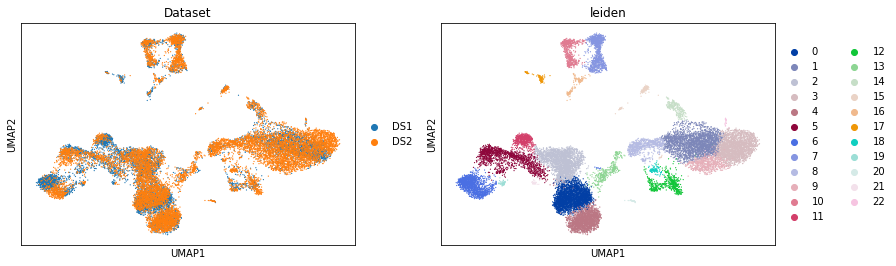

In [79]:
sc.pl.umap(comb_ad, color=['Dataset', 'leiden'])
# Notice the overlap!

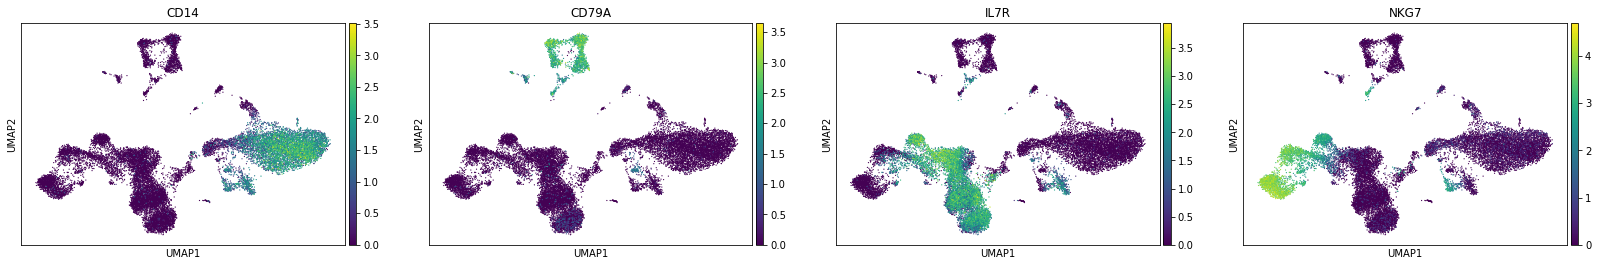

In [80]:
# Some marker genes 
sc.pl.umap(comb_ad, color=['CD14', 'CD79A', 'IL7R', 'NKG7'])

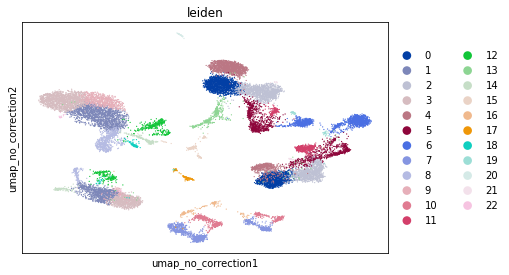

In [81]:
# Plot the corrected clusters on uncorrected umap
sc.pl.scatter(comb_ad, basis='umap_no_correction', color='leiden')

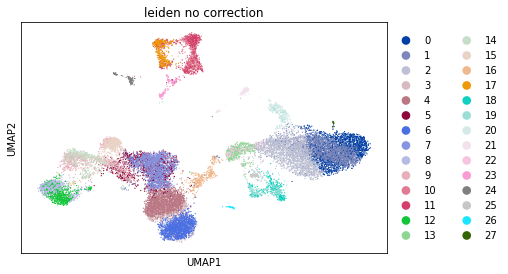

In [82]:
# Plot the uncorrected clusters on corrected umap
sc.pl.scatter(comb_ad, basis='umap', color='leiden_no_correction')

<b> A fun exercise for later </b>
1. Construct a pandas dataframe where rows are corrected clusters and columns are datasets. Each entry in the matrix should represent the fraction of cells in each cluster that belong to the two datasets
2. Visualize as a heatmap [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) will come in handy here
3. Similar to (1), construct a matrix such that each row is uncorrected cluster and each column is a corrected cluster 
4. Visualize (3) using heatmaps. What are your observations?